<a href="https://colab.research.google.com/github/rmedi21/challenge-alura-store/blob/main/AluraStoreLatam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. IMPORTACION Y LIMPIEZA DE DATOS



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# importacion
url = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_1%20.csv"
url2 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_2.csv"
url3 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_3.csv"
url4 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_4.csv"

tienda = pd.read_csv(url)
tienda2 = pd.read_csv(url2)
tienda3 = pd.read_csv(url3)
tienda4 = pd.read_csv(url4)

# concatenacion
tiendas = [tienda, tienda2, tienda3, tienda4]

[tiendas[i].insert(0, "tienda", f'tienda {i + 1}') for i in range(len(tiendas))]

df_tiendas = pd.concat(tiendas)

# formato
df_tiendas['Fecha de Compra'] = pd.to_datetime(df_tiendas['Fecha de Compra'], format='%d/%m/%Y')

df_tiendas = df_tiendas.rename(columns={'Producto': 'producto', 'Categoría del Producto': 'categoria',
                                       'Precio': 'precio', 'Costo de envío': 'costo',
                                       'Fecha de Compra': 'fecha', 'Vendedor': 'vendedor',
                                       'Lugar de Compra': 'lugar', 'Calificación': 'calificacion',
                                       'Método de pago': 'metodo_pago', 'Cantidad de cuotas': 'numero_cuotas'})

# Estilos
colores = ['salmon', 'mediumorchid', 'indigo', 'thistle']

In [ ]:
df_tiendas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9435 entries, 0 to 2357
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   tienda         9435 non-null   object        
 1   producto       9435 non-null   object        
 2   categoria      9435 non-null   object        
 3   precio         9435 non-null   float64       
 4   costo          9435 non-null   float64       
 5   fecha          9435 non-null   datetime64[ns]
 6   vendedor       9435 non-null   object        
 7   lugar          9435 non-null   object        
 8   calificacion   9435 non-null   int64         
 9   metodo_pago    9435 non-null   object        
 10  numero_cuotas  9435 non-null   int64         
 11  lat            9435 non-null   float64       
 12  lon            9435 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(6)
memory usage: 1.0+ MB


# II. ANALISIS

## 1. Análisis de facturación



In [ ]:
# Facturacion por tienda: Tienda 1 tiene la mayor facturacion
df_tiendas.groupby('tienda').agg({'precio': 'sum'}) \
                            .sort_values('precio', ascending=False) \
                            .style.format({'precio': '{:,.0f}'})

,precio
tienda,
tienda 1,"1,150,880,400"
tienda 2,"1,116,343,500"
tienda 3,"1,098,019,600"
tienda 4,"1,038,375,700"


In [ ]:
# Facturacion por año
# Tienda 1 tiene la mayor facturacion excepto en 2022
# Tienda 4 tiene la menor facturacion excepto en 2020
df_tienda_anio = df_tiendas.groupby(['tienda', df_tiendas['fecha'].dt.strftime('%Y')])['precio'] \
                           .sum() \
                           .reset_index() \
                           .rename(columns={'fecha': 'anio', 'precio': 'facturacion'})

pd.crosstab(df_tienda_anio['tienda'], df_tienda_anio['anio'], aggfunc='sum', values=df_tienda_anio['facturacion']) \
  .style.format('{:,.0f}')

anio,2020,2021,2022,2023
tienda,,,,
tienda 1,"368,933,200","362,120,800","316,565,600","103,260,800"
tienda 2,"320,466,600","351,215,500","358,226,500","86,434,900"
tienda 3,"321,707,500","362,954,400","350,438,300","62,919,400"
tienda 4,"330,847,700","347,823,600","302,221,500","57,482,900"


## 2. Ventas por categoría

In [ ]:
# Ventas por categoria y tienda
total_facturacion = df_tiendas['precio'].sum()
total_nro_ventas = df_tiendas['precio'].count()

df_ventas_group = df_tiendas.groupby(['categoria', 'tienda']) \
                            .agg(facturacion=('precio', 'sum'), nro_ventas=('tienda', 'count')) \
                            .reset_index()
df_categoria_group = df_ventas_group.groupby('categoria') \
                                    .agg({'facturacion': 'sum', 'nro_ventas': 'sum'}) \

df_categoria_group['facturacion_%'] = df_ventas_group.groupby('categoria').apply(lambda x: x['facturacion'].sum()/total_facturacion,
                                                                                 include_groups=False)
df_categoria_group['nro_ventas_%'] = df_ventas_group.groupby('categoria').apply(lambda x: x['nro_ventas'].sum()/total_nro_ventas,
                                                                                include_groups=False)
df_categoria_group.reset_index(inplace=True)

In [ ]:
# FUNCIONES AUXILIARES
def exportar_dataframe(df, nombre):
    df2 = pd.DataFrame(data=df.values, columns=df.columns)
    fig, ax = plt.subplots(figsize=(df2.shape[1]*2.1, 0.01))

    for i, tipo in enumerate(df.dtypes):
        match tipo:
            case "object":
                pass
            case "int16" | "int32" | "int64":
                df2.iloc[:,i] = df2.iloc[:,i].apply(lambda x: f'{x:,.0f}')
            case "float32":
                df2.iloc[:,i] = df2.iloc[:,i].apply(lambda x: f'{x:,.0%}')
            case "float64":
                df2.iloc[:,i] = df2.iloc[:,i].apply(lambda x: f'{x:,.2f}')
            case _:
                print('ND')

    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=df2.values, colLabels=df2.columns, loc='top')
    plt.savefig(nombre + '.png', bbox_inches='tight', dpi=300)
    plt.close()
    # plt.show()

In [ ]:
# Facturacion por categoria
# Electronicos y Electrodomesticos representan el 68% de factuacion
# Electronicos, Electrodomesticos y Muebles ocupan el 85% de factuacion
cols = ['categoria', 'facturacion', 'facturacion_%']
df = df_categoria_group[cols].sort_values('facturacion', ascending=False)
df.style.format({'facturacion': '{:,.0f}', 'facturacion_%': '{:,.0%}'})

# df = df.astype(dtype= {"facturacion": "int64", "facturacion_%": "float32"})
# exportar_dataframe(df, 'tabla_categorias')

,categoria,facturacion,facturacion_%
3,Electrónicos,"1,660,576,500",38%
2,Electrodomésticos,"1,324,751,100",30%
7,Muebles,"757,661,000",17%
4,Instrumentos musicales,"348,772,600",8%
1,Deportes y diversión,"142,977,700",3%
5,Juguetes,"73,604,400",2%
0,Artículos para el hogar,"57,579,800",1%
6,Libros,"37,696,100",1%


In [ ]:
# Numero de ventas por categoria
# Muebles y Electronicos son los mas vendidos
df_categoria_group[['categoria', 'nro_ventas', 'nro_ventas_%']].sort_values('nro_ventas', ascending=False) \
                                                               .style.format({'nro_ventas': '{:,.0f}', 'nro_ventas_%': '{:,.0%}'})

,categoria,nro_ventas,nro_ventas_%
7,Muebles,"1,886",20%
3,Electrónicos,"1,772",19%
5,Juguetes,"1,290",14%
2,Electrodomésticos,"1,149",12%
1,Deportes y diversión,"1,113",12%
4,Instrumentos musicales,753,8%
6,Libros,742,8%
0,Artículos para el hogar,730,8%


In [ ]:
# Facturacion por categoria y tienda
# Electrodomestricos y Electronicos representan la mayor facturacion en todas las tiendas (entre 66% y 69%)
df = pd.crosstab(df_ventas_group['tienda'], df_ventas_group['categoria'], aggfunc='sum', values=df_ventas_group['facturacion'],
                 normalize='index')
df.style.format('{:,.0%}')

# df = df.T.reset_index().sort_values('tienda 1', ascending=False)
# df = df.astype({c: "float32" for c in df.columns[1:]})
# exportar_dataframe(df, 'tabla_tiendas_categorias')

categoria,Artículos para el hogar,Deportes y diversión,Electrodomésticos,Electrónicos,Instrumentos musicales,Juguetes,Libros,Muebles
tienda,,,,,,,,
tienda 1,1%,3%,32%,37%,8%,2%,1%,16%
tienda 2,1%,3%,31%,37%,9%,1%,1%,16%
tienda 3,1%,3%,30%,37%,7%,2%,1%,18%
tienda 4,1%,3%,27%,39%,7%,2%,1%,19%


In [ ]:
# Numero de ventas por categoria y tienda
# Muebles y Electronicos son los productos mas vendidos en todas las tiendas
# La distribucion de ventas por categoria es similar en cada una de las tiendas
pd.crosstab(df_ventas_group['tienda'], df_ventas_group['categoria'], aggfunc='sum', values=df_ventas_group['nro_ventas'], normalize='index') \
  .round(2) * 100

categoria,Artículos para el hogar,Deportes y diversión,Electrodomésticos,Electrónicos,Instrumentos musicales,Juguetes,Libros,Muebles
tienda,,,,,,,,
tienda 1,7.0,12.0,13.0,19.0,8.0,14.0,7.0,20.0
tienda 2,8.0,12.0,13.0,18.0,9.0,13.0,8.0,19.0
tienda 3,8.0,12.0,12.0,19.0,8.0,13.0,8.0,21.0
tienda 4,9.0,12.0,11.0,19.0,7.0,14.0,8.0,20.0


## 3. Calificación promedio de la tienda


In [ ]:
# Calificacion promedio de la tienda
# La calificacion es ligeramente mayor en las tiendas 3 y 2
# En todas las tiendas la calificacion es mayor o igual a 4 excepto en la tienda 1
df_tiendas.groupby('tienda')['calificacion'].mean().to_frame() \
                                                  .sort_values('calificacion', ascending=False) \
                                                  .style.format({'calificacion': '{:,.2f}'})

,calificacion
tienda,
tienda 3,4.05
tienda 2,4.04
tienda 4,4.00
tienda 1,3.98


In [ ]:
# La tienda 2 y 3 se ve que mantienen su puntuacion mayor o igual a 4 en todas las categorias, excepto Libros en la tienda 2, y Deportes en la tienda 3
df_tiendas.pivot_table(columns='tienda', index='categoria', values='calificacion', aggfunc='mean') \
          .sort_values(['tienda 1', 'tienda 2', 'tienda 3', 'tienda 4'], ascending=False) \
          .style.format({'tienda 1': '{:,.1f}', 'tienda 2': '{:,.1f}', 'tienda 3': '{:,.1f}', 'tienda 4': '{:,.1f}'})

tienda,tienda 1,tienda 2,tienda 3,tienda 4
categoria,,,,
Juguetes,4.1,4.0,4.2,4.0
Instrumentos musicales,4.0,4.0,4.0,3.9
Electrodomésticos,4.0,4.1,4.0,3.9
Electrónicos,4.0,4.0,4.0,4.0
Libros,4.0,3.9,4.0,4.0
Muebles,3.9,4.1,4.1,4.0
Deportes y diversión,3.9,4.1,3.9,4.1
Artículos para el hogar,3.7,4.1,4.1,4.0


## 4. Productos más y menos vendidos

In [ ]:
# Preparar datos
df_tiendas_producto = df_tiendas.groupby(['tienda', 'producto'])['precio'].count() \
                                .to_frame() \
                                .rename(columns={'precio': 'nro_ventas'})
df_tiendas_producto.reset_index(drop=False, inplace=True)

# Ordenar de mas a menos vendido
df_tiendas_producto['dense_rank'] = df_tiendas_producto.groupby('tienda')['nro_ventas'].rank(method='dense', ascending=False).astype(int)

# Posiciones para filtrar
df_tiendas_producto.groupby('tienda').agg({'dense_rank': ['min', 'max']})

dense_rank    
                min max
tienda                 
tienda 1          1  23
tienda 2          1  25
tienda 3          1  22
tienda 4          1  20

In [ ]:
# Productos mas vendidos por tienda
df_tiendas_producto.query('dense_rank == 1') \
                   .sort_values('dense_rank', ascending=True) \
                   .style.format({'precio': '{:,.0f}'})

,tienda,producto,nro_ventas,dense_rank
1,tienda 1,Armario,60,1
33,tienda 1,Microondas,60,1
48,tienda 1,TV LED UHD 4K,60,1
75,tienda 2,Iniciando en programación,65,1
129,tienda 3,Kit de bancas,57,1
163,tienda 4,Cama box,62,1


In [ ]:
# Productos menos vendidos por tienda
df_tiendas_producto_max = df_tiendas_producto.groupby('tienda')['dense_rank'].max().reset_index()

pd.merge(df_tiendas_producto, df_tiendas_producto_max, left_on=['tienda', 'dense_rank'], right_on=['tienda', 'dense_rank'], how='inner') \
  .sort_values('nro_ventas', ascending=True)

,tienda,producto,nro_ventas,dense_rank
2,tienda 2,Juego de mesa,32,25
0,tienda 1,Auriculares con micrófono,33,23
1,tienda 1,Celular ABXY,33,23
4,tienda 4,Guitarra eléctrica,33,20
3,tienda 3,Bloques de construcción,35,22


## 5. Envío promedio por tienda

In [ ]:
# Costo envio promedio por tienda: La tienda 1 tiene el mayor costo promedio, la tienda 4 el costo menor
df_tiendas.groupby('tienda')['costo'].mean() \
                                     .to_frame() \
                                     .sort_values('costo', ascending=False) \
                                     .style.format({'costo': '{:,.0f}'})

,costo
tienda,
tienda 1,"26,019"
tienda 2,"25,216"
tienda 3,"24,806"
tienda 4,"23,459"


In [ ]:
# Margen: La tienda 1 tiene el mayor margen, por el contrario la tienda 4 tiene el menor margen
df_tiendas.groupby('tienda').apply(lambda x: x['precio'].sum() - x['costo'].sum(), include_groups=False) \
                            .to_frame(name='margen') \
                            .sort_values('margen', ascending=False) \
                            .style.format({'margen': '{:,.0f}'})

,margen
tienda,
tienda 1,"1,089,502,500"
tienda 2,"1,056,858,400"
tienda 3,"1,039,503,000"
tienda 4,"983,058,300"


# III. GRAFICOS

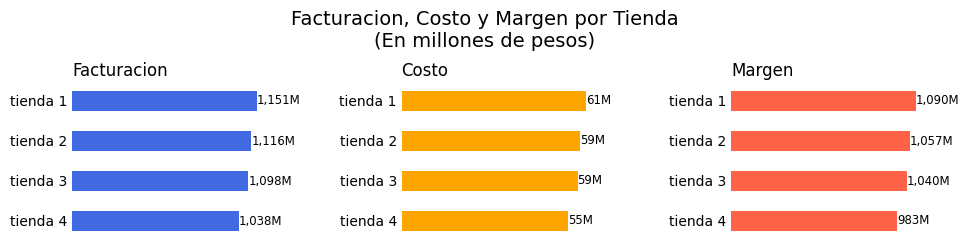

In [ ]:
# Grafico 1: Facturacion, Costo y Margen
# La tienda 4 es la que genera mayor facturacion y tiene mayor margen
colores2 = ['royalblue', 'orange', 'tomato']
df_tiendas_resumen = df_tiendas.groupby('tienda') \
                               .agg(facturacion=('precio', 'sum'), costo=('costo', 'sum'))
df_tiendas_resumen['margen'] = df_tiendas.groupby('tienda') \
                                         .apply(lambda x: x['precio'].sum() - x['costo'].sum(), include_groups=False)

fig, axs = plt.subplots(1, 3, figsize=(11,2))
fig.suptitle('Facturacion, Costo y Margen por Tienda\n(En millones de pesos)', fontsize=14, y=1.25)
fig.subplots_adjust(hspace=0.3, wspace=0.7)     # Ajustar espaciado entre graficos, en % del fig

for i, ax in enumerate(axs.flat):
  concepto = df_tiendas_resumen.columns[i]
  data = df_tiendas_resumen[concepto].sort_values(ascending=True)

  # Grafico
  ax.barh(data.index, data, color=colores2[i], height=0.5)

  # Estilos
  ax.set_frame_on(False)          # quitar borde
  ax.xaxis.set_visible(False)     # ocultar el eje x
  ax.set_title(concepto.capitalize(), loc='left', fontsize=12)
  ax.tick_params(axis='y', which='both', size=0)

  # Agregar valores
  for i, valor in enumerate(data):
    valor_mill = valor / 1000000
    ax.text(valor + 30, i, f"{valor_mill:,.0f}M", color='black', fontsize=8.5, ha='left', va='center')   # x, y, texto, estilos

plt.show()
# plt.savefig("facturacion_costo_margen.png", bbox_inches='tight')
# plt.close()

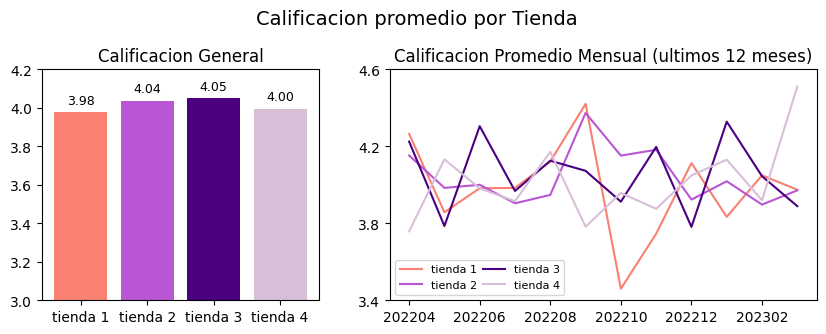

In [ ]:
# Grafico 2: Calificacion promedio por tienda
# Calificacion general
df_tiendas_calif = df_tiendas.groupby('tienda')['calificacion'].mean().reset_index()

# Calificacion ultimos 24 meses
df_tiendas_12um = df_tiendas[df_tiendas['fecha'] > '2022-03-31'].copy()
df_tiendas_12um['periodo'] = df_tiendas_12um['fecha'].dt.strftime('%Y%m')
df_tiendas_calif_ult = df_tiendas_12um.pivot_table(columns='periodo', index='tienda', values='calificacion')

# Subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 3), width_ratios=[1.3, 2])
fig.suptitle('Calificacion promedio por Tienda', fontsize=14, y=1.08)
fig.subplots_adjust(hspace=0.05, wspace=0.2)

# Grafico izquierdo: calificacion general
axs[0].bar(df_tiendas_calif['tienda'], df_tiendas_calif['calificacion'], color=colores)
axs[0].set_ylim(3, 4.2)
axs[0].set_title('Calificacion General')
for i, valor in enumerate(df_tiendas_calif['calificacion']):
  axs[0].text(i, valor + 0.06, f'{valor:,.2f}', color='black', fontsize=9, ha='center', va='center')

# Grafico derecho: evolucion de calificacion ultimos 12 meses
i = 0
for index, row in df_tiendas_calif_ult.iterrows():
  axs[1].plot(row.index, row.values, label=index, color=colores[i])
  i += 1
axs[1].set_yticks([3.4, 3.8, 4.2, 4.6])
axs[1].xaxis.set_major_locator(plt.MultipleLocator(2))
axs[1].legend(prop={'size': 8}, loc='lower left', ncols=2, labelspacing=0.5, columnspacing=0.5)
axs[1].set_title('Calificacion Promedio Mensual (ultimos 12 meses)')

plt.show()
# plt.savefig("calificacion_promedio.png", bbox_inches='tight')
# plt.close()

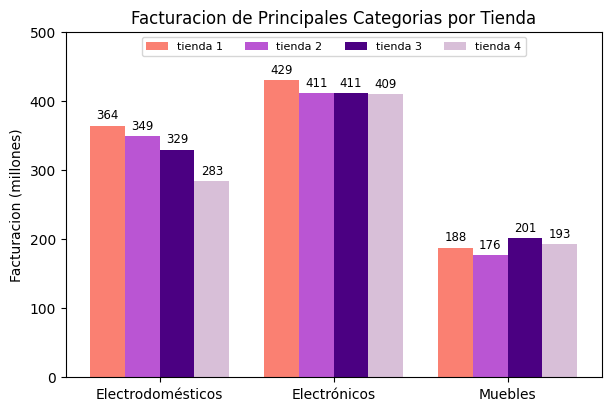

In [ ]:
# Grafico 3: Categorias mas vendidas por tienda
# Dataset
cats = df_tiendas.groupby('categoria').agg({'precio': 'sum'}) \
                                      .sort_values('precio', ascending=False) \
                                      .head(3) \
                                      .index.tolist()
df_tienda_categoria = df_tiendas.query('categoria in @cats')
df_tienda_categoria = pd.crosstab(df_tienda_categoria['tienda'], df_tienda_categoria['categoria'], \
                                  aggfunc='sum', values=df_tienda_categoria['precio'])

# Grafico
x = np.arange(len(df_tienda_categoria.columns))
ancho_barra = 0.2
m = 0

fig, ax = plt.subplots(layout='constrained', figsize=(6,4))

# Se pinta por atributo
for index, row in df_tienda_categoria.iterrows():
  offset = ancho_barra * m
  rects = ax.bar(x + offset, row / 1000000, ancho_barra, label=index, color=colores[m])
  ax.bar_label(rects, padding=3, fmt='{:,.0f}', fontsize=8.5)
  m += 1

ax.set_title('Facturacion de Principales Categorias por Tienda')
ax.set_ylabel('Facturacion (millones)', fontsize=10)
ax.set_ylim(0, 500)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xticks(x + ancho_barra * 1.5, df_tienda_categoria.columns)
ax.legend(loc='upper center', ncols=4, prop={'size': 8})

plt.show()
# plt.savefig("facturacion_categorias.png", bbox_inches='tight')
# plt.close()

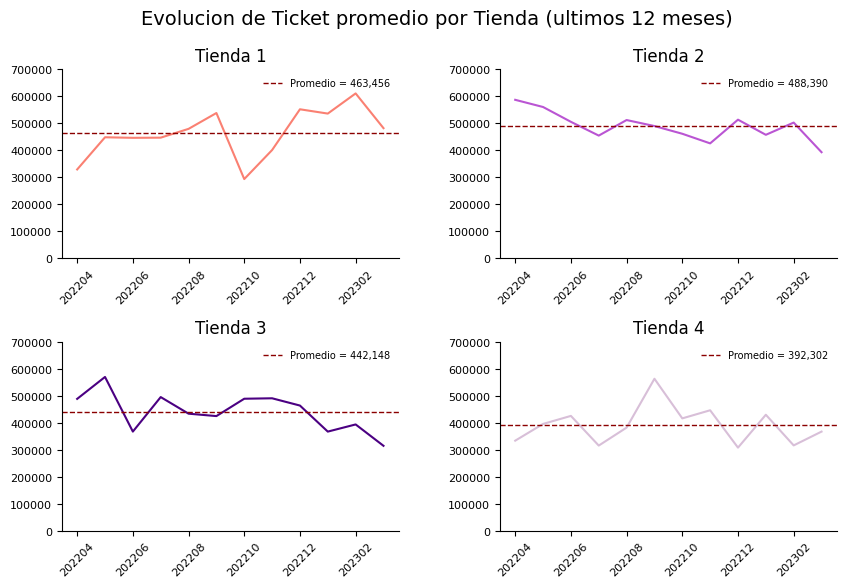

In [ ]:
# Grafico 4: Ticket promedio
# Las tienda 4 tienen el menor ticket promedio
df_tiendas_periodo = df_tiendas.groupby(['tienda', df_tiendas['fecha'].dt.strftime('%Y%m')]) \
                               .agg(ticket_prom=('precio', 'mean')) \
                               .reset_index(drop=False)

df_tiendas_periodo['periodo'] = pd.to_datetime(df_tiendas_periodo['fecha'] + '01', format='%Y%m%d')
df_tiendas_periodo.drop('fecha', inplace=True, axis=1)

tiendas = ['tienda 1', 'tienda 2', 'tienda 3', 'tienda 4']
periodo_inicial = "2022-04-01"
ymin, ymax = 0, 700000

fig, axs = plt.subplots(2, 2, figsize=(10,6))
fig.suptitle('Evolucion de Ticket promedio por Tienda (ultimos 12 meses)', fontsize=14)
fig.subplots_adjust(hspace=0.44, wspace=0.3)

for i, ax in enumerate(axs.flat):
  tienda = 'tienda ' + str(i + 1)
  df_tienda = df_tiendas_periodo.query('tienda == @tienda and periodo >= @periodo_inicial')
  media = df_tienda['ticket_prom'].mean()
  ax.plot(df_tienda['periodo'].dt.strftime('%Y%m'), df_tienda['ticket_prom'], color=colores[i])
  ax.axhline(y=media, color='darkred', linestyle='--', linewidth=1, label=f'Promedio = {media:,.0f}')
  ax.set_title(label=tienda.capitalize(), fontsize=12)

for ax in axs.ravel():
  ax.set_ylim(ymin, ymax)
  ax.xaxis.set_major_locator(plt.MultipleLocator(2))
  ax.tick_params(labelsize=8)
  ax.tick_params('x', labelrotation=45)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.legend(loc='best', frameon=False, fontsize=7)

plt.show()
# plt.savefig("ticket_promedio_24m.png")
# plt.close()

# IV. INFORME FINAL

## Introducción
El Sr. Juan es dueño de cuatro tiendas y desea vender una de estas para realizar una nueva inversión. Entonces debemos evaluar estas tiendas para recomendar cual debemos vender.


## Criterios de Decisión
Según el análisis realizado, se ha establecido los siguientes criterios para elegir la tienda con el menor perfomance:
* Facturación
* Margen
* Ticket promedio
* Venta en las principales categorías
* Calificación de los clientes
<br/><br/>

Procederemos a desarrollar cada uno de estos criterios.
<br/>
* **Facturación**<br/>
En el análisis gráfico de 'Facturación, Costo y Margen', se puede observar que la tienda que tiene menor facturación es la tienda 4 con 1,038 millones de pesos.<br/>
![Facturacion costo y margen por tienda](https://raw.githubusercontent.com/rmedi21/challenge-alura-store/refs/heads/main/img/facturacion_costo_margen.png)
<br/><br/>
* **Margen**<br/>
Definimos margen como el precio menos el costo, y en el gráfico anterior se puede notar que la tienda 4 tiene el menor margen con 983 millones.
<br/><br/><br/>
* **Ticket promedio**<br/>
Por el lado del ticket promedio, vemos en el evolutivo de los últimos 12 meses que el ticket de la tienda 4 es el mas bajo con 392,302 pesos.
![Ticket promedio de los ultimos 12 meses](https://raw.githubusercontent.com/rmedi21/challenge-alura-store/refs/heads/main/img/ticket_promedio_12m.png)
<br/><br/>
* **Venta en las principales categorias**<br/>
Las principales categorias según facturación son Electrónicos, Electrodoméstricos y Muebles, que representan un 85%:
![Tabla categorias](https://raw.githubusercontent.com/rmedi21/challenge-alura-store/refs/heads/main/img/tabla_categorias.png)<br/>
Se puede observar que estas tres categorías son las más relevantes en todas las tiendas:
![Tabla tiendas categorias](https://raw.githubusercontent.com/rmedi21/challenge-alura-store/refs/heads/main/img/tabla_tiendas_categorias.png)<br/><br/>
En base a lo anterior, se puede observar que la tienda 4 tiene la menor facturación en las 2 categorías principales, Electrónicos y Electrodomésticos:<br>
![Facturacion principales categorias](https://raw.githubusercontent.com/rmedi21/challenge-alura-store/refs/heads/main/img/facturacion_categorias.png)
<br/><br/>
* **Calificación de los clientes**<br/>
En este aspecto se puede observar que las tiendas con la menor calificación son la tienda 1 (3.98) y la tienda 4 (4.00). Si tomamos la puntuación promedio mensual en los últimos 12 meses, se puede observar que la tienda 1 tiene variaciones más prolongadas, y las tiendas 2 y 3 suelen mantener las evaluaciones mas elevadas:
![Facturacion en principales categorias](https://raw.githubusercontent.com/rmedi21/challenge-alura-store/refs/heads/main/img/calificacion_promedio.png)



## Conclusiones
En base al análisis anterior se puede determinar que en todos los criterios económicos (facturación, margen, ticket promedio, facturación en las principales categorías) la tienda 4 es la que tiene el peor performance.<br><br>
En lo que respecta a la calificación de los clientes, la tienda 4 tiene la segunda menor puntación, sólo por encima de la tienda 1 que es precisamente la tienda que tiene la mejor performance en los criterios económicos. <br><br>
Por lo tanto podemos concluir que la **tienda 4** es la que tiene el peor puntaje en cada uno de estos criterios, por lo que se sugiere que se venda esta tienda.